In [1]:
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic, lonlat
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
file_path1 = '/Users/yokij/Desktop/Capstone/NYC/NYPD_Complaint_Data_Current__Year_To_Date.csv'
data1 = pd.read_csv(file_path1, low_memory=False)
data1 = data1.drop(columns=['New Georeferenced Column'])
data1['CMPLNT_FR_DT'] = pd.to_datetime(data1['CMPLNT_FR_DT'], errors='coerce')
data1 = data1.sort_values(by='CMPLNT_FR_DT', ascending=True)
data1 = data1[(data1['CMPLNT_FR_DT'] >= pd.Timestamp('2023-01-01')) & (data1['CMPLNT_FR_DT'] <= pd.Timestamp('2023-05-31'))]

In [3]:
file_path2 = '/Users/yokij/Desktop/Capstone/NYC/NYPD_Complaint_Data_Historic.csv'
data2 = pd.read_csv(file_path2, low_memory=False)
data2['CMPLNT_FR_DT'] = pd.to_datetime(data2['CMPLNT_FR_DT'], errors='coerce')
data2 = data2.sort_values(by='CMPLNT_FR_DT', ascending=True)
data2 = data2[(data2['CMPLNT_FR_DT'] >= pd.Timestamp('2018-01-01')) & (data2['CMPLNT_FR_DT'] <= pd.Timestamp('2022-12-31'))]

In [4]:
df = pd.concat([data1, data2])

In [5]:
#delete data if its category is NaN
df = df[df['KY_CD'].notna()] #KY_CD is more general than PD_CD
df = df[df['LAW_CAT_CD'].notna()] #This records three categories(felony,misdemeanor and violation)
df = df[df['Lat_Lon'].notna()]

In [6]:
df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
405841,261253580,102.0,QUEENS,2023-01-01,22:00:00,01/02/2023,06:20:00,COMPLETED,(null),NaN,...,U,NaN,18-24,ASIAN / PACIFIC ISLANDER,M,1030707.0,190546.0,40.689560,-73.832478,"(40.68956, -73.832478)"
244547,261208845,69.0,BROOKLYN,2023-01-01,18:55:00,01/01/2023,19:02:00,COMPLETED,(null),NaN,...,M,NaN,25-44,BLACK,F,1013831.0,169688.0,40.632382,-73.893422,"(40.632382, -73.893422)"
295876,261291509,61.0,BROOKLYN,2023-01-01,16:28:00,01/01/2023,16:30:00,COMPLETED,(null),NaN,...,F,NaN,45-64,WHITE,F,997560.0,158908.0,40.602832,-73.952065,"(40.602832, -73.952065)"
354453,261370802,44.0,BRONX,2023-01-01,23:30:00,01/01/2023,23:35:00,COMPLETED,(null),NaN,...,M,NaN,25-44,WHITE,M,1006250.0,245145.0,40.839516,-73.920489,"(40.839516, -73.920489)"
338175,261199165,105.0,QUEENS,2023-01-01,13:57:00,01/01/2023,14:10:00,COMPLETED,(null),NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,1060291.0,207786.0,40.736676,-73.725610,"(40.736676, -73.72561)"


zipcode https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/ny_new_york_zip_codes_geo.min.json

In [7]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/ny_new_york_zip_codes_geo.min.json'
zipcode = gpd.read_file(file_path, low_memory=False)

In [8]:
zipcode.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,36,12205,3612205,B5,G6350,S,40906445,243508,+42.7187855,-073.8292399,N,"POLYGON ((-73.87052 42.75123, -73.86861 42.756..."
1,36,12009,3612009,B5,G6350,S,135241924,2168637,+42.6975663,-074.0355422,N,"POLYGON ((-74.10891 42.65300, -74.10889 42.653..."
2,36,14804,3614804,B5,G6350,S,144718714,232123,+42.3172588,-077.8479358,N,"POLYGON ((-77.92747 42.34775, -77.92632 42.347..."
3,36,14836,3614836,B5,G6350,S,77612958,131305,+42.5429182,-077.8781933,N,"MULTIPOLYGON (((-77.95599 42.47433, -77.95600 ..."
4,36,14536,3614536,B5,G6350,S,47193482,425175,+42.5439751,-078.0836709,N,"POLYGON ((-78.05030 42.53850, -78.05024 42.538..."


In [9]:
# Function to convert string coordinates to Point geometry
def create_point_from_string(coord_str):
    match = re.match(r'\(([^,]+), ([^)]+)\)', coord_str)
    if match:
        lat, lon = map(float, match.groups())
        return Point(lon, lat)
    return None

df['geometry'] = df['Lat_Lon'].apply(create_point_from_string)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
zipcode.set_crs(epsg=4326, inplace=True)
result = gpd.sjoin(gdf, zipcode, how="left", op='within')

/Users/yokij/opt/anaconda3/lib/python3.9/site-packages/geopandas/sindex.py:87: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (idx, item) in enumerate(geometry.iteritems())


In [10]:
result.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
405841,261253580,102.0,QUEENS,2023-01-01,22:00:00,01/02/2023,06:20:00,COMPLETED,(null),NaN,...,11419,3611419,B5,G6350,S,2924898.0,0.0,+40.6886731,-073.8229179,N
244547,261208845,69.0,BROOKLYN,2023-01-01,18:55:00,01/01/2023,19:02:00,COMPLETED,(null),NaN,...,11236,3611236,B5,G6350,S,9311387.0,89767.0,+40.6394133,-073.9006642,N
295876,261291509,61.0,BROOKLYN,2023-01-01,16:28:00,01/01/2023,16:30:00,COMPLETED,(null),NaN,...,11229,3611229,B5,G6350,S,5611289.0,127424.0,+40.6012928,-073.9444926,N
354453,261370802,44.0,BRONX,2023-01-01,23:30:00,01/01/2023,23:35:00,COMPLETED,(null),NaN,...,10452,3610452,B5,G6350,S,2550148.0,0.0,+40.8373899,-073.9234295,N
338175,261199165,105.0,QUEENS,2023-01-01,13:57:00,01/01/2023,14:10:00,COMPLETED,(null),NaN,...,11426,3611426,B5,G6350,S,3493966.0,0.0,+40.7364585,-073.7223762,N


In [11]:
result.set_index('CMPLNT_FR_DT', inplace=True)

In [12]:
weekly_data = result.groupby('ZCTA5CE10').resample('W').size().reset_index(name='total_count')

In [13]:
weekly_geodata = pd.merge(weekly_data, zipcode[['ZCTA5CE10']], on='ZCTA5CE10', how='left')
weekly_geodata.head()

,ZCTA5CE10,CMPLNT_FR_DT,total_count
0,10001,2018-01-07,2
1,10001,2018-01-14,2
2,10001,2018-01-21,0
3,10001,2018-01-28,3
4,10001,2018-02-04,3


In [14]:
weekly_data.to_csv('weekly_data.csv', index=False)

Population 2020 https://data.census.gov/table/DECENNIALDHC2020.P1?g=160XX00US3651000$8600000

In [15]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_DECENNIALDHC2020.csv'
pop = pd.read_csv(file_path, low_memory=False)

In [16]:
pop.head()

,Label (Grouping),ZCTA5 10001,ZCTA5 10002,ZCTA5 10003,ZCTA5 10004,ZCTA5 10005,ZCTA5 10006,ZCTA5 10007,ZCTA5 10009,ZCTA5 10010,...,ZCTA5 11434,ZCTA5 11435,ZCTA5 11436,ZCTA5 11439,ZCTA5 11451,ZCTA5 11691,ZCTA5 11692,ZCTA5 11693,ZCTA5 11694,ZCTA5 11697
0,Total,"32,612","82,155","57,076","4,287","10,639","4,282","8,421","61,716","33,991",...,"66,964","58,980","20,620","2,376",1,"64,673","22,776","12,467","19,780","4,468"


In [17]:
# Set the header row as the df header
pop_transposed = pop.transpose()
pop_transposed = pop_transposed.reset_index()
new_header = pop_transposed.iloc[0]  
pop_transposed = pop_transposed[1:]  
pop_transposed.columns = new_header  

In [18]:
pop = pop_transposed.rename(columns={"Label (Grouping)": "ZCTA5CE10"})
pop['ZCTA5CE10'] = pop['ZCTA5CE10'].str.replace('ZCTA5 ', '')
pop = pop.iloc[:, [0, 1]]  
pop.head()

,ZCTA5CE10,Total
1,10001,"32,612"
2,10002,"82,155"
3,10003,"57,076"
4,10004,"4,287"
5,10005,"10,639"


In [19]:
pop.shape

(215, 2)

In [20]:
crime = pd.merge(weekly_geodata, pop, on='ZCTA5CE10', how='left')
crime.head()

,ZCTA5CE10,CMPLNT_FR_DT,total_count,Total
0,10001,2018-01-07,2,"32,612"
1,10001,2018-01-14,2,"32,612"
2,10001,2018-01-21,0,"32,612"
3,10001,2018-01-28,3,"32,612"
4,10001,2018-02-04,3,"32,612"


In [21]:
crime['Total'] = pd.to_numeric(crime['Total'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)
crime['crime_rate'] = (crime['total_count'] / crime['Total']) * 10000
crime = crime.rename(columns={'Total': "total_population"})
crime = crime.rename(columns={"CMPLNT_FR_DT": "week"})
crime = crime[crime['total_population'] != 0]

In [22]:
crime.head()

,ZCTA5CE10,week,total_count,total_population,crime_rate
0,10001,2018-01-07,2,32612,0.613271
1,10001,2018-01-14,2,32612,0.613271
2,10001,2018-01-21,0,32612,0.000000
3,10001,2018-01-28,3,32612,0.919907
4,10001,2018-02-04,3,32612,0.919907


In [23]:
df_plot = crime
df_plot.set_index('week', inplace=True)

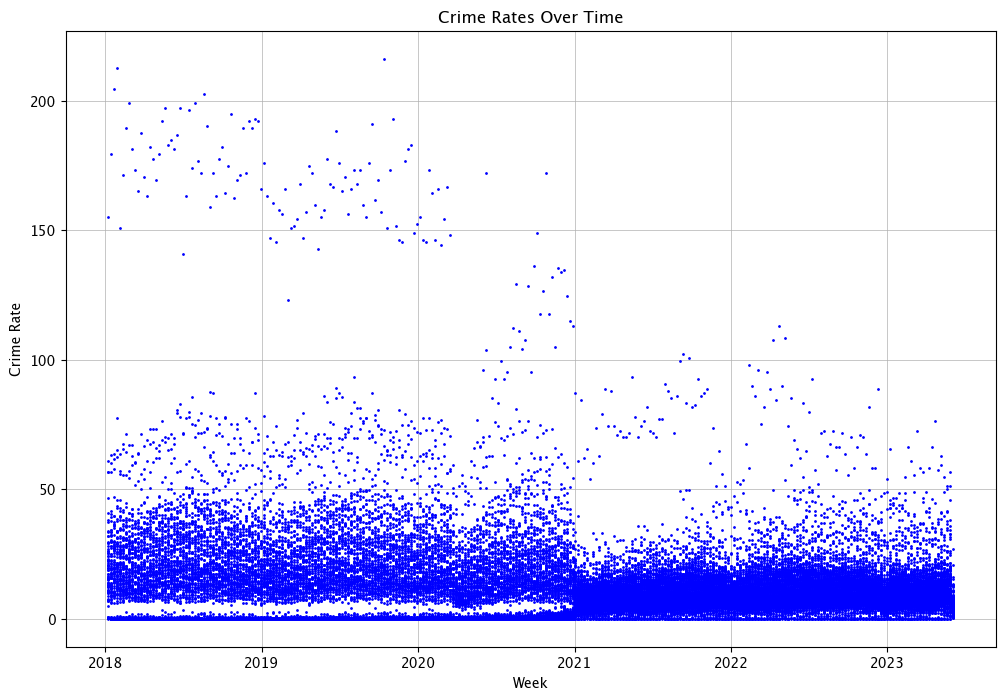

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

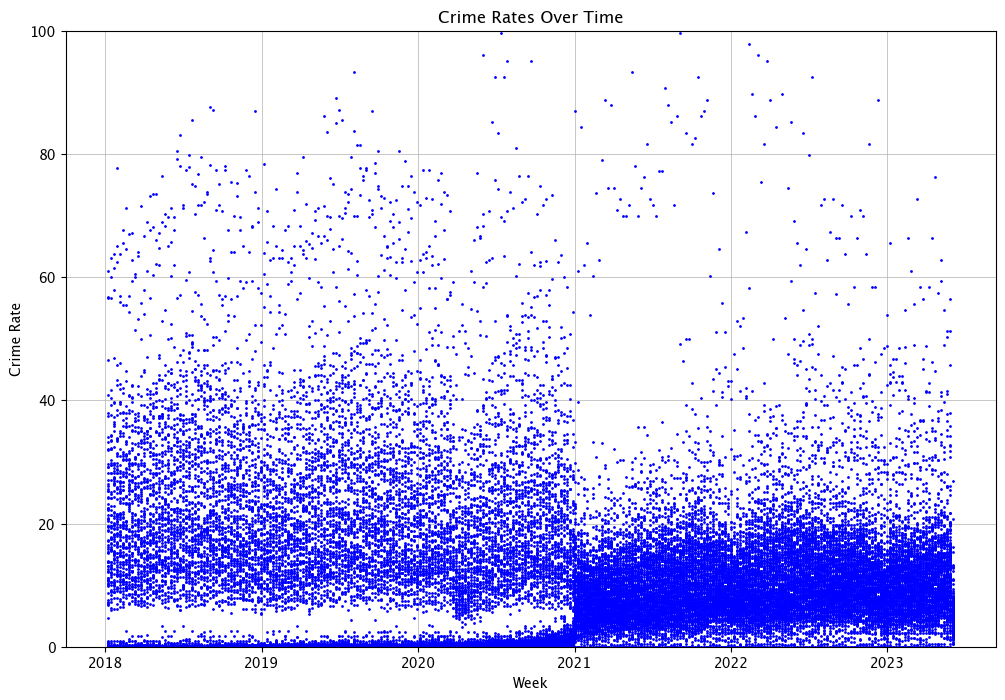

In [25]:
# zoom in
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.ylim(0, 100)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

In [26]:
statistics = crime.describe().T
print(statistics)

                    count          mean           std     min           25%  \
total_count       48317.0     52.059855     56.291097     0.0      1.000000   
total_population  48317.0  50251.092079  27001.297290  1814.0  29686.000000   
crime_rate        48317.0     10.797648     14.258218     0.0      0.353232   

                           50%           75%            max  
total_count          36.000000     86.000000     457.000000  
total_population  45799.000000  69703.000000  117110.000000  
crime_rate            8.104013     14.743264     216.240467  


In [27]:
print(crime['total_count'].median())
print(crime['total_population'].median())
print(crime['crime_rate'].median())

36.0
45799.0
8.10401324829992


# S2301 Employment

https://data.census.gov/table/ACSST5Y2022.S2301?g=160XX00US3651000$8600000

In [28]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2022S2301.csv'
df = pd.read_csv(file_path, low_memory=False)
df2022 = df[['NAME', 'S2301_C03_001E', 'S2301_C04_001E']]
df2022 = df2022.iloc[1:].reset_index(drop=True)
df2022.columns = ['ZCTA5CE10', '2022e/pop', '2022un_rate']
df2022['ZCTA5CE10'] = df2022['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2022.head()

,ZCTA5CE10,2022e/pop,2022un_rate
0,10001,69.5,4.3
1,10002,51.0,7.6
2,10003,64.3,4.7
3,10004,83.6,0.4
4,10005,91.7,3.4


In [29]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2021S2301.csv'
df = pd.read_csv(file_path, low_memory=False)
df2021 = df[['NAME', 'S2301_C03_001E', 'S2301_C04_001E']]
df2021 = df2021.iloc[1:].reset_index(drop=True)
df2021.columns = ['ZCTA5CE10', '2021e/pop', '2021un_rate']
df2021['ZCTA5CE10'] = df2021['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2021.head()

,ZCTA5CE10,2021e/pop,2021un_rate
0,10001,71.0,4.1
1,10002,49.9,7.5
2,10003,63.9,5.1
3,10004,84.3,1.6
4,10005,91.4,3.2


In [30]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2020S2301.csv'
df = pd.read_csv(file_path, low_memory=False)
df2020 = df[['NAME', 'S2301_C03_001E', 'S2301_C04_001E']]
df2020 = df2020.iloc[1:].reset_index(drop=True)
df2020.columns = ['ZCTA5CE10', '2020e/pop', '2020un_rate']
df2020['ZCTA5CE10'] = df2020['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2020.head()

,ZCTA5CE10,2020e/pop,2020un_rate
0,10001,70.8,4.5
1,10002,49.6,6.8
2,10003,64.9,4.5
3,10004,82.7,3.3
4,10005,90.5,2.3


In [31]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2019S2301.csv'
df = pd.read_csv(file_path, low_memory=False)
df2019 = df[['NAME', 'S2301_C03_001E', 'S2301_C04_001E']]
df2019 = df2019.iloc[1:].reset_index(drop=True)
df2019.columns = ['ZCTA5CE10', '2019e/pop', '2019un_rate']
df2019['ZCTA5CE10'] = df2019['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2019.head()

,ZCTA5CE10,2019e/pop,2019un_rate
0,10001,68.2,5.0
1,10002,50.5,6.2
2,10003,62.8,4.8
3,10004,80.4,3.5
4,10005,88.3,3.1


In [32]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2018S2301.csv'
df = pd.read_csv(file_path, low_memory=False)
df2018 = df[['NAME', 'S2301_C03_001E', 'S2301_C04_001E']]
df2018 = df2018.iloc[1:].reset_index(drop=True)
df2018.columns = ['ZCTA5CE10', '2018e/pop', '2018un_rate']
df2018['ZCTA5CE10'] = df2018['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2018.head()

,ZCTA5CE10,2018e/pop,2018un_rate
0,10001,67.8,4.5
1,10002,50.5,7.0
2,10003,63.3,5.7
3,10004,76.8,4.5
4,10005,87.2,3.1


In [33]:
# merge them sequentially
from functools import reduce
dfs = [df2018, df2019, df2020, df2021, df2022]
def merge_dfs(dfs, key, how='outer'):
    return reduce(lambda left, right: pd.merge(left, right, on=key, how=how), dfs)
employment = merge_dfs(dfs, 'ZCTA5CE10', 'outer')
employment.head()

,ZCTA5CE10,2018e/pop,2018un_rate,2019e/pop,2019un_rate,2020e/pop,2020un_rate,2021e/pop,2021un_rate,2022e/pop,2022un_rate
0,10001,67.8,4.5,68.2,5.0,70.8,4.5,71.0,4.1,69.5,4.3
1,10002,50.5,7.0,50.5,6.2,49.6,6.8,49.9,7.5,51.0,7.6
2,10003,63.3,5.7,62.8,4.8,64.9,4.5,63.9,5.1,64.3,4.7
3,10004,76.8,4.5,80.4,3.5,82.7,3.3,84.3,1.6,83.6,0.4
4,10005,87.2,3.1,88.3,3.1,90.5,2.3,91.4,3.2,91.7,3.4


In [34]:
employment.shape

(218, 11)

# S1701 poverty

https://data.census.gov/table/ACSST5Y2022.S1701?g=160XX00US3651000$8600000

In [35]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2022S1701.csv'
df = pd.read_csv(file_path, low_memory=False)
df2022 = df[['NAME', 'S1701_C03_001E']]
df2022 = df2022.iloc[1:].reset_index(drop=True)
df2022.columns = ['ZCTA5CE10', '2022p_rate']
df2022['ZCTA5CE10'] = df2022['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2022.head()

,ZCTA5CE10,2022p_rate
0,10001,15.9
1,10002,26.1
2,10003,12.1
3,10004,3.1
4,10005,5.2


In [36]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2021S1701.csv'
df = pd.read_csv(file_path, low_memory=False)
df2021 = df[['NAME', 'S1701_C03_001E']]
df2021 = df2021.iloc[1:].reset_index(drop=True)
df2021.columns = ['ZCTA5CE10', '2021p_rate']
df2021['ZCTA5CE10'] = df2021['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2021.head()

,ZCTA5CE10,2021p_rate
0,10001,13.7
1,10002,27.0
2,10003,10.8
3,10004,2.9
4,10005,3.5


In [37]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2020S1701.csv'
df = pd.read_csv(file_path, low_memory=False)
df2020 = df[['NAME', 'S1701_C03_001E']]
df2020 = df2020.iloc[1:].reset_index(drop=True)
df2020.columns = ['ZCTA5CE10', '2020p_rate']
df2020['ZCTA5CE10'] = df2020['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2020.head()

,ZCTA5CE10,2020p_rate
0,10001,11.6
1,10002,27.5
2,10003,8.9
3,10004,2.8
4,10005,7.5


In [38]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2019S1701.csv'
df = pd.read_csv(file_path, low_memory=False)
df2019 = df[['NAME', 'S1701_C03_001E']]
df2019 = df2019.iloc[1:].reset_index(drop=True)
df2019.columns = ['ZCTA5CE10', '2019p_rate']
df2019['ZCTA5CE10'] = df2019['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2019.head()

,ZCTA5CE10,2019p_rate
0,10001,13.1
1,10002,27.4
2,10003,9.2
3,10004,1.3
4,10005,9.5


In [39]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2018S1701.csv'
df = pd.read_csv(file_path, low_memory=False)
df2018 = df[['NAME', 'S1701_C03_001E']]
df2018 = df2018.iloc[1:].reset_index(drop=True)
df2018.columns = ['ZCTA5CE10', '2018p_rate']
df2018['ZCTA5CE10'] = df2018['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2018.head()

,ZCTA5CE10,2018p_rate
0,10001,13.3
1,10002,27.7
2,10003,8.5
3,10004,2.2
4,10005,9.5


In [40]:
# merge them sequentially
from functools import reduce
dfs = [df2018, df2019, df2020, df2021, df2022]
def merge_dfs(dfs, key, how='outer'):
    return reduce(lambda left, right: pd.merge(left, right, on=key, how=how), dfs)
poverty = merge_dfs(dfs, 'ZCTA5CE10', 'outer')
poverty.head()

,ZCTA5CE10,2018p_rate,2019p_rate,2020p_rate,2021p_rate,2022p_rate
0,10001,13.3,13.1,11.6,13.7,15.9
1,10002,27.7,27.4,27.5,27.0,26.1
2,10003,8.5,9.2,8.9,10.8,12.1
3,10004,2.2,1.3,2.8,2.9,3.1
4,10005,9.5,9.5,7.5,3.5,5.2


In [41]:
poverty.shape

(218, 6)

# S1901 Household Income 

https://data.census.gov/table/ACSST5Y2022.S1901?g=160XX00US3651000$8600000

In [42]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2022S1901.csv'
df = pd.read_csv(file_path, low_memory=False)
df2022 = df[['NAME', 'S1901_C01_012E', 'S1901_C01_013E']]
df2022 = df2022.iloc[1:].reset_index(drop=True)
df2022.columns = ['ZCTA5CE10', '2022in_median', '2022in_mean']
df2022['ZCTA5CE10'] = df2022['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2022.head()

,ZCTA5CE10,2022in_median,2022in_mean
0,10001,106509,176483
1,10002,43362,86843
2,10003,152863,250384
3,10004,232543,342833
4,10005,189886,251095


In [43]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2021S1901.csv'
df = pd.read_csv(file_path, low_memory=False)
df2021 = df[['NAME', 'S1901_C01_012E', 'S1901_C01_013E']]
df2021 = df2021.iloc[1:].reset_index(drop=True)
df2021.columns = ['ZCTA5CE10', '2021in_median', '2021in_mean']
df2021['ZCTA5CE10'] = df2021['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2021.head()

,ZCTA5CE10,2021in_median,2021in_mean
0,10001,101409,170154
1,10002,37093,76115
2,10003,137533,222765
3,10004,216017,317203
4,10005,197188,225528


In [44]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2020S1901.csv'
df = pd.read_csv(file_path, low_memory=False)
df2020 = df[['NAME', 'S1901_C01_012E', 'S1901_C01_013E']]
df2020 = df2020.iloc[1:].reset_index(drop=True)
df2020.columns = ['ZCTA5CE10', '2020in_median', '2020in_mean']
df2020['ZCTA5CE10'] = df2020['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2020.head()

,ZCTA5CE10,2020in_median,2020in_mean
0,10001,96787,166167
1,10002,35607,70204
2,10003,129981,211756
3,10004,204949,325028
4,10005,184681,218441


In [45]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2019S1901.csv'
df = pd.read_csv(file_path, low_memory=False)
df2019 = df[['NAME', 'S1901_C01_012E', 'S1901_C01_013E']]
df2019 = df2019.iloc[1:].reset_index(drop=True)
df2019.columns = ['ZCTA5CE10', '2019in_median', '2019in_mean']
df2019['ZCTA5CE10'] = df2019['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2019.head()

,ZCTA5CE10,2019in_median,2019in_mean
0,10001,92840,160300
1,10002,36982,69323
2,10003,118161,196931
3,10004,190223,249586
4,10005,189702,225453


In [46]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2018S1901.csv'
df = pd.read_csv(file_path, low_memory=False)
df2018 = df[['NAME', 'S1901_C01_012E', 'S1901_C01_013E']]
df2018 = df2018.iloc[1:].reset_index(drop=True)
df2018.columns = ['ZCTA5CE10', '2018in_median', '2018in_mean']
df2018['ZCTA5CE10'] = df2018['ZCTA5CE10'].str.replace('ZCTA5 ', '')
df2018.head()

,ZCTA5CE10,2018in_median,2018in_mean
0,10001,88526,151628
1,10002,35859,68315
2,10003,112131,189885
3,10004,157645,218650
4,10005,173333,208186


In [47]:
from functools import reduce
dfs = [df2018, df2019, df2020, df2021, df2022]
def merge_dfs(dfs, key, how='outer'):
    return reduce(lambda left, right: pd.merge(left, right, on=key, how=how), dfs)
income = merge_dfs(dfs, 'ZCTA5CE10', 'outer')
income.head()

,ZCTA5CE10,2018in_median,2018in_mean,2019in_median,2019in_mean,2020in_median,2020in_mean,2021in_median,2021in_mean,2022in_median,2022in_mean
0,10001,88526,151628,92840,160300,96787,166167,101409,170154,106509,176483
1,10002,35859,68315,36982,69323,35607,70204,37093,76115,43362,86843
2,10003,112131,189885,118161,196931,129981,211756,137533,222765,152863,250384
3,10004,157645,218650,190223,249586,204949,325028,216017,317203,232543,342833
4,10005,173333,208186,189702,225453,184681,218441,197188,225528,189886,251095


In [48]:
income.shape

(218, 11)

# Regression

In [49]:
crime = crime.reset_index()
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate
0,2018-01-07,10001,2,32612,0.613271
1,2018-01-14,10001,2,32612,0.613271
2,2018-01-21,10001,0,32612,0.000000
3,2018-01-28,10001,3,32612,0.919907
4,2018-02-04,10001,3,32612,0.919907


In [50]:
#poverty rate
crime['week'] = pd.to_datetime(crime['week'])
crime['year'] = crime['week'].dt.year
poverty.set_index('ZCTA5CE10', inplace=True)
crime['p_rate'] = 0.0

year_to_pov_col = {2018: '2018p_rate', 2019: '2019p_rate', 2020: '2020p_rate', 2021: '2021p_rate', 2022: '2022p_rate'}

def get_poverty_rate(row):
    # Get the poverty rate column name for the year
    pov_col = year_to_pov_col.get(row['year'])
    # If the year is not in the dictionary, return NaN
    if pov_col is None:
        return pd.NA
    return poverty.loc[row['ZCTA5CE10'], pov_col]

crime['p_rate'] = crime.apply(get_poverty_rate, axis=1)
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,year,p_rate
0,2018-01-07,10001,2,32612,0.613271,2018,13.3
1,2018-01-14,10001,2,32612,0.613271,2018,13.3
2,2018-01-21,10001,0,32612,0.000000,2018,13.3
3,2018-01-28,10001,3,32612,0.919907,2018,13.3
4,2018-02-04,10001,3,32612,0.919907,2018,13.3


In [51]:
employment.set_index('ZCTA5CE10', inplace=True)
year_to_e_pop_col = {year: f'{year}e/pop' for year in range(2018, 2023)}
year_to_un_rate_col = {year: f'{year}un_rate' for year in range(2018, 2023)}

def get_employment_data(row, e_pop_col_dict, un_rate_col_dict, employment):
    e_pop_col = e_pop_col_dict.get(row['year'])
    un_rate_col = un_rate_col_dict.get(row['year'])
    e_pop_rate = employment.at[row['ZCTA5CE10'], e_pop_col] if e_pop_col else pd.NA
    un_rate = employment.at[row['ZCTA5CE10'], un_rate_col] if un_rate_col else pd.NA
    return e_pop_rate, un_rate

crime[['e/pop', 'un_rate']] = crime.apply(lambda row: get_employment_data(row, year_to_e_pop_col, year_to_un_rate_col, employment), axis=1, result_type='expand')
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,year,p_rate,e/pop,un_rate
0,2018-01-07,10001,2,32612,0.613271,2018,13.3,67.8,4.5
1,2018-01-14,10001,2,32612,0.613271,2018,13.3,67.8,4.5
2,2018-01-21,10001,0,32612,0.000000,2018,13.3,67.8,4.5
3,2018-01-28,10001,3,32612,0.919907,2018,13.3,67.8,4.5
4,2018-02-04,10001,3,32612,0.919907,2018,13.3,67.8,4.5


In [52]:
income.set_index('ZCTA5CE10', inplace=True)
year_to_in_median_col = {year: f'{year}in_median' for year in range(2018, 2023)}
year_to_in_mean_col = {year: f'{year}in_mean' for year in range(2018, 2023)}

def get_income_data(row, in_median_col_dict, in_mean_col_dict, income):
    in_median_col = in_median_col_dict.get(row['year'])
    in_mean_col = in_mean_col_dict.get(row['year'])
    in_median = income.at[row['ZCTA5CE10'], in_median_col] if in_median_col else pd.NA
    in_mean = income.at[row['ZCTA5CE10'], in_mean_col] if in_mean_col else pd.NA
    return in_median, in_mean

crime[['in_median', 'in_mean']] = crime.apply(lambda row: get_income_data(row, year_to_in_median_col, year_to_in_mean_col, income), axis=1, result_type='expand')

crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,year,p_rate,e/pop,un_rate,in_median,in_mean
0,2018-01-07,10001,2,32612,0.613271,2018,13.3,67.8,4.5,88526,151628
1,2018-01-14,10001,2,32612,0.613271,2018,13.3,67.8,4.5,88526,151628
2,2018-01-21,10001,0,32612,0.000000,2018,13.3,67.8,4.5,88526,151628
3,2018-01-28,10001,3,32612,0.919907,2018,13.3,67.8,4.5,88526,151628
4,2018-02-04,10001,3,32612,0.919907,2018,13.3,67.8,4.5,88526,151628


In [55]:
crime_df = crime
crime_df['in_median'] = crime_df['in_median'].astype(str)
crime_df['in_median'] = crime_df['in_median'].replace('250,000+', '250000')

crime_df['p_rate'] = pd.to_numeric(crime_df['p_rate'], errors='coerce')
crime_df['un_rate'] = pd.to_numeric(crime_df['un_rate'], errors='coerce')

crime_df.dropna(subset=['p_rate', 'un_rate', 'in_median', 'crime_rate'], inplace=True)

X = crime_df[['p_rate', 'un_rate', 'in_median']].astype(float) 
Y = crime_df['crime_rate'].astype(float) 

model = sm.OLS(Y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             crime_rate   R-squared (uncentered):                   0.381
Model:                            OLS   Adj. R-squared (uncentered):              0.380
Method:                 Least Squares   F-statistic:                              9037.
Date:                Mon, 05 Feb 2024   Prob (F-statistic):                        0.00
Time:                        16:18:11   Log-Likelihood:                     -1.8020e+05
No. Observations:               44136   AIC:                                  3.604e+05
Df Residuals:                   44133   BIC:                                  3.604e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# ACS 2022 Population

In [ ]:
file_path = '/Users/yokij/Desktop/Capstone/NYC_ACSDP5Y2022DP05.csv'
pop = pd.read_csv(file_path, low_memory=False)

ACS 2022: https://data.census.gov/table/ACSDP5Y2022.DP05?g=160XX00US3651000$8600000

In [ ]:
pop.head()

In [ ]:
pop_transposed = pop.transpose()
pop_transposed = pop_transposed.reset_index()
new_header = pop_transposed.iloc[0]  
pop_transposed = pop_transposed[1:]  
pop_transposed.columns = new_header  # Set the header row as the df header

In [ ]:
pop_transposed.head()

In [ ]:
df = pop_transposed
df.columns = df.columns.str.strip()

if 'level_0' in df.columns:
    df.drop('level_0', axis=1, inplace=True)
df.reset_index(inplace=True)

df_estimates = df[df['Label (Grouping)'].str.contains('!!Estimate')]
df_estimates = df_estimates[['Label (Grouping)', 'Total population']]
df_estimates.set_index(df_estimates['Label (Grouping)'].str.replace('!!Estimate', ''), inplace=True)
df_estimates.drop('Label (Grouping)', axis=1, inplace=True)
pop = df_estimates.reset_index(drop=False)
pop.head()

In [ ]:
pop = pop.rename(columns={"Label (Grouping)": "ZCTA5CE10"})
pop['ZCTA5CE10'] = pop['ZCTA5CE10'].str.replace('ZCTA5 ', '')
pop = pop.iloc[:, [0, 1]]  # Keeps only the first two columns
pop.head()

In [ ]:
merged_df = pd.merge(weekly_geodata, pop, on='ZCTA5CE10', how='left')
merged_df.head()

In [ ]:
merged_df['Total population'] = pd.to_numeric(merged_df['Total population'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)
merged_df['crime_rate'] = (merged_df['total_count'] / merged_df['Total population']) * 10000
merged_df = merged_df.rename(columns={'Total population': "total_population"})
merged_df = merged_df.rename(columns={"CMPLNT_FR_DT": "week"})

In [ ]:
merged_df.head()

In [ ]:
merged_df = merged_df[merged_df['total_population'] != 0]

In [ ]:
merged_df['ZCTA5CE10'].nunique()

In [ ]:
merged_df.shape

In [ ]:
merged_df.to_csv('weekly_data.csv', index=False)

In [ ]:
df_plot = merged_df
df_plot.set_index('week', inplace=True)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

In [ ]:
statistics = merged_df.describe().T
print(statistics)

In [ ]:
print(merged_df['total_count'].median())
print(merged_df['total_population'].median())
print(merged_df['crime_rate'].median())

In [ ]:
# zoom in
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.ylim(0, 100)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()